# FIND FLOES AND CALCULATE FLOE STATISTICS

## Find floes and calculate floe basic floe statistics with ATL10 product
- Read ATL10 files
- Determine floe statistics (floe chord length, floe freeboard, lead width, etc.) using the ATL10 files in the Weddell Sea
- Create the result files in .pkl (pickled) and .nc (netCDF4) formats
- The pickled file contains floe information: floe length/freeboard for all detected floes, freeboard profiles for all detected floes, freeboard distribution, and lead distributions

Credited by Younghyun Koo (kooala317@gmail.com), Mukund Gupta, and Heather Regan

## (1) Import necessary libraries

In [7]:
import warnings
warnings.filterwarnings('ignore')

import os, glob
import csv
import numpy as np
# import icepyx as ipx
from os import listdir
from os.path import isfile, join
import h5py
import matplotlib.pylab as plt
from math import *
import random
# import time
import pandas as pd
from tqdm import tqdm
import pickle

import cartopy.crs as ccrs
import datetime as dt
from shapely.geometry import Point
import geopandas
import scipy.stats as stats
import netCDF4
from netCDF4 import Dataset    # Note: python is case-sensitive!
from netCDF4 import date2num,num2date

from pyproj import Proj, transform
from shapely.geometry import Polygon
from sklearn.neighbors import KernelDensity

%load_ext autoreload
%autoreload 2
from functions_floes import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## (3) Process the floe analysis for all ATL10 files in the Weddell Sea (for loop)

In [8]:
# All ATL10 files stored in a folder

th_fb = 0.8
ib_filtering = True
region = "entire"
lead_types = ["S"]

for target_year in [2019]:
# for th_fb in [0.8, 1.0]:

    files = glob.glob(f"D:\\Floes\\ATL10\\ATL10-02_{target_year}*.h5")

    # Test for three regions of the Weddell Sea
    for ib_filtering in [True, False]:
    # for region in ["entire"]:
        
        if region == "west":
            bbox = [-62, -73, -45, -60]
        elif region == "south":
            bbox = [-62, -77.6, -15, -73]
        elif region == "entire":
            bbox = [-62, -77.6, -15, -60]
    
        for lead_type in lead_types: # "SD", "S", "F001", "F002"
    
            if ib_filtering:
                nc_name = f'D:\\Floes\\array\\Grid_fb_v6_{region}{target_year}_w_ibfiltering_fb{th_fb}.nc'
            else:
                nc_name = f'D:\\Floes\\array\\Grid_fb_v6_{region}{target_year}_wo_ibfiltering.nc'
            
            with Dataset(nc_name, mode='w') as ncfile:
                
                # INITIALIZE NC FILE ==================================================================
                # Make grid for Weddell Sea (projection: NSIDC sea ice polar stereographic South - EPSG 3412)
                wide = 2500000
                y0 = 500000
                x0 = -2800000
                xp = np.arange(x0, x0+wide, 25000)
                yp = np.arange(y0, y0+wide, 25000)
    
                xx, yy = np.meshgrid(xp, yp)
                lats, lons = transform(Proj("EPSG:3412"), Proj("EPSG:4326"), xx, yy) 
    
                x_len = len(xp)
                y_len = len(yp)
                
                # CREATE NC FILE VARIABLES ================================
                x_dim = ncfile.createDimension('x', x_len)     # latitude axis
                y_dim = ncfile.createDimension('y', y_len)    # longitude axis
                time_dim = ncfile.createDimension('time', None) # unlimited axis (can be appended to).
                for dim in ncfile.dimensions.items():
                    print(dim)
    
                ## XY grid ================================================
                x = ncfile.createVariable('x', np.float32, ('x',))
                x.units = 'meters'
                x.long_name = 'Center_x_values'
                y = ncfile.createVariable('y', np.float32, ('y',))
                y.units = 'meters'
                y.long_name = 'Center_y_values'
    
                ## Time ================================================
                time = ncfile.createVariable('time', np.float64, ('time',))
                time.units = 'hours since 1800-01-01'
                time.long_name = 'time'
    
                ## latitude & longitude ================================================
                latitude = ncfile.createVariable('lat', np.float64,('y','x',)) # note: unlimited dimension is leftmost
                latitude.units = 'degrees_north' # degrees Kelvin
                latitude.long_name = "latitude"
    
                longitude = ncfile.createVariable('lon', np.float64,('y','x',)) # note: unlimited dimension is leftmost
                longitude.units = 'degrees_east' # degrees Kelvin
                longitude.long_name = "longitude"
    
                ## Data variables ================================================
                fb_mode = ncfile.createVariable('fb_mode', np.float64,('time','x','y')) # note: unlimited dimension is leftmost
                fb_mode.units = 'meters' # degrees meter
                fb_mode.standard_name = 'modal_freeboard' # this is a CF standard name
                
                fb_mean = ncfile.createVariable('fb_mean', np.float64,('time','x','y')) # note: unlimited dimension is leftmost
                fb_mean.units = 'meters' # degrees meter
                fb_mean.standard_name = 'mean_freeboard' # this is a CF standard name
                
                fb_med = ncfile.createVariable('fb_med', np.float64,('time','x','y')) # note: unlimited dimension is leftmost
                fb_med.units = 'meters' # degrees meter
                fb_med.standard_name = 'median_freeboard' # this is a CF standard name
                
                fb_std = ncfile.createVariable('fb_std', np.float64,('time','x','y')) # note: unlimited dimension is leftmost
                fb_std.units = 'meters' # degrees meter
                fb_std.standard_name = 'standard_deviation_freeboard' # this is a CF standard name
    
                fr_ridge = ncfile.createVariable('fr_ridge', np.float64,('time','x','y')) # note: unlimited dimension is leftmost
                # fr_ridge.units = 'meters' # no units
                fr_ridge.standard_name = 'ridge_fraction' # this is a CF standard name
    
                h_ridge = ncfile.createVariable('h_ridge', np.float64,('time','x','y')) # note: unlimited dimension is leftmost
                h_ridge.units = 'meters' # degrees meter
                h_ridge.standard_name = 'mean_ridge_height' # this is a CF standard name
    
                fr_lead = ncfile.createVariable('fr_lead', np.float64,('time','x','y')) # note: unlimited dimension is leftmost
                # fr_lead.units = 'meters' # no units
                fr_lead.standard_name = 'lead_fraction' # this is a CF standard name

                fb_count = ncfile.createVariable('fb_count', np.float64,('time','x','y')) # note: unlimited dimension is leftmost
                # fr_lead.units = 'meters' # no units
                fb_count.standard_name = 'Number of ATL10 freeboard measurement points' # this is a CF standard name
    
                ib_cnt = ncfile.createVariable('ib_cnt', np.float64,('time','x','y')) # note: unlimited dimension is leftmost
                # floe_cnt.units = 'meters' # no units
                ib_cnt.standard_name = 'number of icebergs/landfast ice' # this is a CF standard name

                ib_len = ncfile.createVariable('ib_len', np.float64,('time','x','y')) # note: unlimited dimension is leftmost
                ib_len.units = 'meters' # no units
                ib_len.standard_name = 'total length of icebergs/landfast ice points' # this is a CF standard name
                
                x[:] = xp
                y[:] = yp
    
                latitude[:] = lats
                longitude[:] = lons
                ## ============================================================================
                
                nc_idx = 0
                
                print(region, lead_type)
    
                # Initializing freeboard distribution bin ranges
                step = 0.1
                ITD_bin_ranges = np.arange(0, 4.0+step, step) #np.arange(0.1, 1.5, num=50)
                ITD_bins = 0.5*(ITD_bin_ranges[0:-1] + ITD_bin_ranges[1:])
    
                #### ITD parameters ####
                cnt_file = 0
                ITD_all = np.zeros((len(ITD_bins),len(files)))
                year_all = np.zeros(len(files))
                month_all = np.zeros(len(files))
                day_all = np.zeros(len(files))
                valid_idx = []
    
                #### Floe parameters ####
                floe_year = np.array([])
                floe_month = np.array([])
                floe_day = np.array([])
                floe_len = np.array([])
                floe_lat = np.array([])
                floe_lon = np.array([])
                floe_fb_mean = np.array([])
                floe_fb_med = np.array([])
                floe_fb_std = np.array([])
                lead_width = np.array([])
                lead_position = np.array([])
                nprof = 50
    
                #### Lead parameters ####
                lead_width_bin_ranges = np.arange(10, 3000, 10)
                lead_width_bin_means = 0.5*(lead_width_bin_ranges[0:-1] + lead_width_bin_ranges[1:])
                binned_lead_count_all = np.zeros((len(lead_width_bin_means), len(files)))
                binned_lead_spacings_all = np.zeros((len(lead_width_bin_means), len(files)))
    
                first = True
                
                ## LOOP FOR ALL ATL10 FILES =================================================
                for k in tqdm(range(0, len(files))):
                    filename = files[k]
                    date = os.path.basename(filename)[9:9+14]
                    year = int(date[:4])
                    month = int(date[4:6])
                    day = int(date[6:8])
                    valid_beam = 0
    
                    year_all[k] = year
                    month_all[k] = month
                    day_all[k] = day
    
                    first_beam = True
                    first_floe = True
                    first_ib = True
                    
                    # Initialize grid (for nc file) -----------------------------------------
                    grid_fb_mode = np.zeros(np.shape(xx)) * np.nan
                    grid_fb_std = np.zeros(np.shape(xx)) * np.nan
                    grid_fr_ridge = np.zeros(np.shape(xx)) * np.nan
                    grid_h_ridge = np.zeros(np.shape(xx)) * np.nan
                    grid_fr_lead = np.zeros(np.shape(xx)) * np.nan
                    grid_floe_leng = np.zeros(np.shape(xx)) * np.nan
                    grid_floe_cnt = np.zeros(np.shape(xx)) * np.nan
                    grid_ib_cnt = np.zeros(np.shape(xx)) * np.nan
                    grid_ib_len = np.zeros(np.shape(xx)) * np.nan
                
                    polygons = []
                    w = 12500
                    for xi in xp[:]:
                        for yi in yp[:]:
                            polygons.append(Polygon([(xi-w,yi-w), (xi+w, yi-w), (xi+w, yi+w), (xi-w, yi+w)]))
    
                    grid = geopandas.GeoDataFrame({'geometry':polygons}, crs = "EPSG:3412")
                    grid['id'] = grid.index
                    # -----------------------------------------------------------------
                    
                    df2 = pd.DataFrame({'lat': [], 'lon': []})
                    df_floe = pd.DataFrame({'lat': [], 'lon': [], 'floe_len': []})
    
                    df_raw = read_ATL10(filename, bbox)
    
                    if len(df_raw) > 0:
    
                        strong_beams = pd.unique(df_raw['beam'])
        
                        for beam in strong_beams:
        
                            df = df_raw.loc[df_raw['beam']==beam, :].reset_index(drop = True)
                            
                            ib_mask2, df_ib = determine_iceberg(df, th_fb = th_fb)
                            df_ib2, ib_mask3 = combine_icebergs(df, df_ib, ib_mask2, th_fb)
    
                            ########## APPLY Iceberg Filting (YES or NO) ##########
                            if len(df_ib2) > 0:
                                if first_ib:
                                    df_ib_all = df_ib2
                                    first_ib = False
                                else:
                                    df_ib_all = pd.concat([df_ib_all, df_ib2]).reset_index(drop = True)
                                
                            if ib_filtering:
                                df = df[ib_mask3 == 0].reset_index(drop = True)
                            ######################################################
                            
                            lat = df['lat'].values
                            lon = df['lon'].values
                            seg_x = df['seg_x'].values
                            seg_len = df['seg_len'].values
                            fb = df['fb'].values
                            stype = df['stype'].values
                            refsur_ndx = df['refsur_ndx'].values
    
                            freeboard_mode, sample_ndx = modal_profile(fb, seg_x, refsur_ndx)
    
                            ridge = np.zeros(np.shape(fb))
                            # Ridge or not? (threshold 0.6 m above level (mode) freeboard)
                            ridge[fb > freeboard_mode + 0.6] = 1
        
                            df['fb_mode'] = freeboard_mode
                            df['ridge'] = ridge
        
                            if len(df) > 0 and np.sum(np.isnan(fb)) != len(fb):
                                
                                first_beam = False
        
                                if k not in valid_idx:
                                    valid_idx.append(k)
        
                                ITD, _ = np.histogram(fb, bins=ITD_bin_ranges)
                                ITD_all[:, k] += ITD
                                
                                # DETERMINE LEAD --------------------------------------------------
                                lead_mask = np.zeros(len(fb))
                                if lead_type == "S":  # Specular leads
                                    lead_mask[(stype <= 5) & (stype>= 2) & (fb < 0.1)] = 1 
                                elif lead_type == "SD":  # Specular + dark leads
                                    lead_mask[(stype <= 9) & (stype>= 2) & (fb < 0.1)] = 1 
                                elif lead_type == "F001":  # Freeboard heights (0.01 m)
                                    lead_mask[fb < 0.01] = 1
                                elif lead_type == "F002":  # Freeboard heights (0.02 m)
                                    lead_mask[fb < 0.02] = 1
                                # ------------------------------------------------------------------
                                
                                df['lead'] = lead_mask
                                
                                df = df.dropna().reset_index(drop = True)
                                
                                df2 = pd.concat([df2, df], ignore_index=True)
                                
                                # CALCULATE FLOE STATISTICS (floe length, floe freeboard, lead width, etc.)
                                # floe_len0, fb_mean0, fb_med0, fb_std0, floe_lat0, floe_lon0, floe_idx, floe_loc, lead_width0, lead_pos0, floe_profiles0 = \
                                # get_floe_length(fb, lead_mask, seg_x, seg_len, lat, lon, nprof)

                                '''
                                if len(floe_len0) > 0:
                                    first_floe = False
                                    df_floe0 = pd.DataFrame({'lat': floe_lat0, 'lon': floe_lon0, 'floe_len': floe_len0, 'floe_fb': fb_mean0})
                                    df_floe = pd.concat([df_floe, df_floe0], ignore_index=True) #df_floe.append(df_floe0).reset_index(drop=True)
                                    
                                    # Combine the temporary record to the entire record
                                    floe_year = np.append(floe_year, np.ones(len(floe_len0))*year)
                                    floe_month = np.append(floe_month, np.ones(len(floe_len0))*month)
                                    floe_day = np.append(floe_day, np.ones(len(floe_len0))*day)
                                    floe_len = np.append(floe_len, floe_len0)
                                    floe_fb_mean = np.append(floe_fb_mean, fb_mean0)
                                    floe_fb_med = np.append(floe_fb_med, fb_med0)
                                    floe_fb_std = np.append(floe_fb_std, fb_std0)
                                    floe_lat = np.append(floe_lat, floe_lat0)
                                    floe_lon = np.append(floe_lon, floe_lon0)
        
                                    if first:
                                        floe_profiles = floe_profiles0
                                        first = False
                                    else:
                                        floe_profiles = np.append(floe_profiles, floe_profiles0, axis = 1)
        
                                if len(lead_width0) > 0:
                                    binned_lead_count0, binned_lead_spacings0 = get_lead_width_spacing_correlation(lead_width0,lead_pos0, lead_width_bin_ranges)
                                    binned_lead_count_all[:, k] += binned_lead_count0
                                    binned_lead_spacings_all[:, k] += binned_lead_spacings0
                                    valid_beam += 1
                                '''
    
                    if first_beam == False:
                        
                        # Combine the results to the NC file grid -------------------------------------
                        gdf = geopandas.GeoDataFrame(df2, crs="EPSG:4326",
                                                     geometry=geopandas.points_from_xy(df2.lon, df2.lat)).to_crs("EPSG:3412")
    
                        # gdf_floe = geopandas.GeoDataFrame(df_floe, crs="EPSG:4326",
                        #                                   geometry=geopandas.points_from_xy(df_floe.lon, df_floe.lat)).to_crs("EPSG:3412")
                        # gdf_floe = gdf_floe.sjoin(grid, how="left").dropna()
    
                        left_df = gdf.sjoin(grid, how="left").dropna()
    
                        ridge = left_df.groupby("id").apply(calculate_ridge)
                        array_fb_mode = [s[0] for s in ridge.values]
                        array_fr_ridge = [s[1] for s in ridge.values]
                        array_h_ridge = [s[2] for s in ridge.values]
                        array_fb_mean = [s[3] for s in ridge.values]
                        array_fb_med = [s[4] for s in ridge.values]
                        array_fb_std = [s[5] for s in ridge.values]
                        array_fr_lead = left_df.groupby("id")["lead"].apply(calculate_lead).values
                        array_fb_count = left_df.groupby("id")["lat"].count()
                        
                        # array_floe_len = gdf_floe.groupby("id")["floe_len"].mean()
                        # array_floe_cnt = gdf_floe.groupby("id")["lat"].count()
    
                        grid.loc[ridge.index, "fb_mode"] = array_fb_mode
                        grid.loc[ridge.index, "fr_ridge"] = array_fr_ridge
                        grid.loc[ridge.index, "h_ridge"] = array_h_ridge
                        grid.loc[ridge.index, "fb_mean"] = array_fb_mean
                        grid.loc[ridge.index, "fb_med"] = array_fb_med
                        grid.loc[ridge.index, "fb_std"] = array_fb_std
                        grid.loc[ridge.index, "fr_lead"] = array_fr_lead
                        grid.loc[ridge.index, "fb_count"] = array_fb_count
                        # grid.loc[array_floe_cnt.index, "floe_len"] = array_floe_len.values
                        # grid.loc[array_floe_cnt.index, "floe_cnt"] = array_floe_cnt.values
    
                        fb_mode[nc_idx ,:,:] = grid["fb_mode"].values.reshape(np.shape(xx)) #.transpose()
                        fb_mean[nc_idx ,:,:] = grid["fb_mean"].values.reshape(np.shape(xx)) #.transpose()
                        fb_med[nc_idx ,:,:] = grid["fb_med"].values.reshape(np.shape(xx)) #.transpose()
                        fb_std[nc_idx ,:,:] = grid["fb_std"].values.reshape(np.shape(xx)) #.transpose()
                        fr_ridge[nc_idx ,:,:] = grid["fr_ridge"].values.reshape(np.shape(xx)) #.transpose()
                        h_ridge[nc_idx ,:,:] = grid["h_ridge"].values.reshape(np.shape(xx)) #.transpose()
                        fr_lead[nc_idx ,:,:] = grid["fr_lead"].values.reshape(np.shape(xx)) #.transpose()
                        fb_count[nc_idx,:,:] = grid["fb_count"].values.reshape(np.shape(xx))
                        
                        # floe_leng[nc_idx ,:,:] = grid["floe_len"].values.reshape(np.shape(xx)).transpose()
                        # floe_cnt[nc_idx ,:,:] = grid["floe_cnt"].values.reshape(np.shape(xx)).transpose()
                        time[nc_idx] = date2num(dt.datetime.strptime(date, "%Y%m%d%H%M%S"), time.units)
                        
                        if first_ib == False:
        
                            gdf_ib = geopandas.GeoDataFrame(df_ib_all, crs="EPSG:4326",
                                                            geometry=geopandas.points_from_xy(df_ib_all.lon, df_ib_all.lat)).to_crs("EPSG:3412")
                            gdf_ib = gdf_ib.sjoin(grid, how="left").dropna()
        
                            array_ib_cnt = gdf_ib.groupby("id")["lat"].count()
                            array_ib_len = gdf_ib.groupby("id")["width"].sum()    
                            grid.loc[array_ib_cnt.index, "ib_cnt"] = array_ib_cnt.values
                            grid.loc[array_ib_len.index, "ib_len"] = array_ib_len.values
                            grid_ib_cnt = grid["ib_cnt"].values.reshape(np.shape(xx)) #.transpose()
                            grid_ib_len = grid["ib_len"].values.reshape(np.shape(xx)) #.transpose()
                            
                        ib_cnt[nc_idx ,:,:] = grid_ib_cnt
                        ib_len[nc_idx ,:,:] = grid_ib_len
    
                        nc_idx += 1
                        
                    # if valid_beam > 0:
                    #     binned_lead_spacings_all[:, k] = binned_lead_spacings_all[:, k] / valid_beam


('x', <class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 100)
('y', <class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 100)
('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 0)
entire S


100%|████████████████████████████████████████████████████████████████████████████| 1169/1169 [1:31:37<00:00,  4.70s/it]


('x', <class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 100)
('y', <class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 100)
('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 0)
entire S


100%|████████████████████████████████████████████████████████████████████████████| 1169/1169 [1:30:01<00:00,  4.62s/it]


False

In [31]:
gdf_ib

,lat,lon,seg_x,id_st,id_en,fb_mean_left,fb_max,fb_min,fb_std_left,width,...,id,fb_mode,fr_ridge,h_ridge,fr_lead,fb_mean_right,fb_med,fb_std_right,floe_len,floe_cnt


## Test some results

In [7]:
%matplotlib widget
plt.scatter(floe_lon[:4], floe_lat[:4], c=floe_month[:4])

(100, 100) (100, 100) (100, 100) (100, 100)


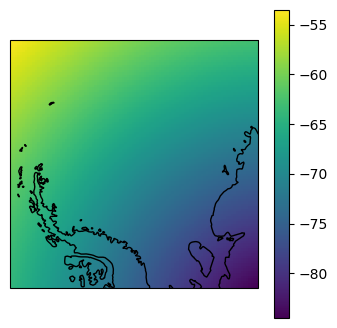

In [141]:
width = 2500000
y0 = 500000
x0 = -2800000
xp = np.arange(x0, x0+width, 25000)
yp = np.arange(y0, y0+width, 25000)

xx, yy = np.meshgrid(xp, yp)
lats, lons = transform(Proj("EPSG:3412"), Proj("EPSG:4326"), xx, yy)
print(xx.shape, yy.shape, lats.shape, lons.shape)

fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi= 100, subplot_kw={'projection': ccrs.SouthPolarStereo()})
m = ax.pcolormesh(xx, yy, lats)
fig.colorbar(m, ax=ax)
ax.coastlines()
ax.grid()

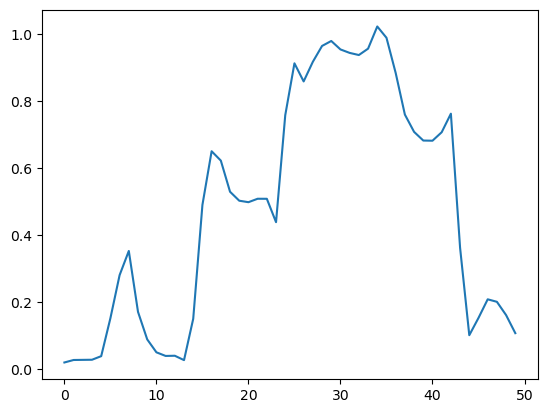

In [423]:
plt.plot(floe_profiles[:, 150])

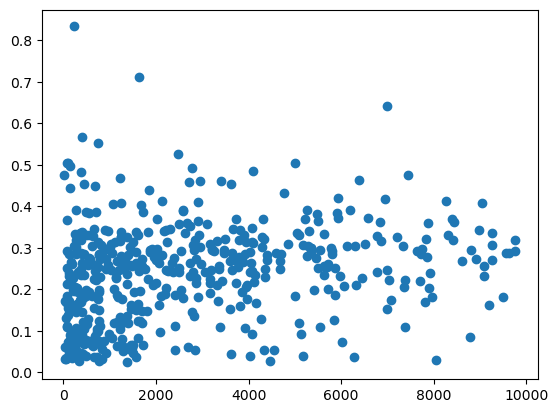

In [369]:
plt.scatter(floe_len, floe_fb_std)

(28000000.0, 28040000.0)

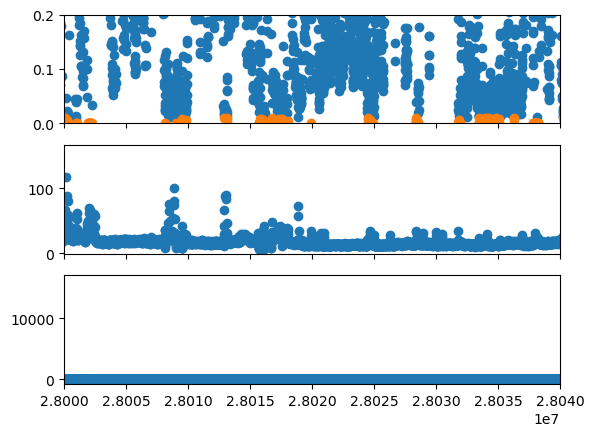

In [187]:
fig,ax = plt.subplots(3, 1, sharex = True)
ax[0].scatter(seg_dist[lead_mask==0], freeboard[lead_mask==0])
ax[0].scatter(seg_dist[lead_mask==1], freeboard[lead_mask==1])
ax[0].set_ylim(0, 0.2)
ax[1].scatter(seg_dist, seg_len)
ax[2].scatter(seg_dist, delta_dist)
# plt.scatter(lead_position, lead_length/lead_length)
# plt.ylim(0,100)
ax[2].set_xlim(28000000, 28040000)

## Ross Sea

In [4]:
# All ATL10 files stored in a folder

th_fb = 0.8
ib_filtering = True
region = "Ross"

lead_types = ["S"]

for target_year in [2023]:
# for th_fb in [0.8, 1.0]:

    files = glob.glob(f"D:\\Ross\\ATL10_h5\\ATL10-02_{target_year}*.h5")
    
    bbox = [160, -80, -150, -60] # Ross Sea

    for ib_filtering in [False]:
    
        for lead_type in lead_types: # "SD", "S", "F001", "F002"
    
            if ib_filtering:
                nc_name = f'D:\\Floes\\array\\Grid_fb_v6_{region}{target_year}_w_ibfiltering_fb{th_fb}.nc'
            else:
                nc_name = f'D:\\Floes\\array\\Grid_fb_v6_{region}{target_year}_wo_ibfiltering.nc'
            
            with Dataset(nc_name, mode='w') as ncfile:
                
                # INITIALIZE NC FILE ==================================================================
                # Make grid for Weddell Sea (projection: NSIDC sea ice polar stereographic South - EPSG 3412)
                xp = np.arange(-2000000, 1500001, 25000)
                yp = np.arange(-3200000, -800001, 25000)
    
                xx, yy = np.meshgrid(xp, yp)
                lats, lons = transform(Proj("EPSG:3412"), Proj("EPSG:4326"), xx, yy) 
    
                x_len = len(xp)
                y_len = len(yp)
                
                # CREATE NC FILE VARIABLES ================================
                x_dim = ncfile.createDimension('x', x_len)     # latitude axis
                y_dim = ncfile.createDimension('y', y_len)    # longitude axis
                time_dim = ncfile.createDimension('time', None) # unlimited axis (can be appended to).
                for dim in ncfile.dimensions.items():
                    print(dim)
    
                ## XY grid ================================================
                x = ncfile.createVariable('x', np.float32, ('x',))
                x.units = 'meters'
                x.long_name = 'Center_x_values'
                y = ncfile.createVariable('y', np.float32, ('y',))
                y.units = 'meters'
                y.long_name = 'Center_y_values'
    
                ## Time ================================================
                time = ncfile.createVariable('time', np.float64, ('time',))
                time.units = 'hours since 1800-01-01'
                time.long_name = 'time'
    
                ## latitude & longitude ================================================
                latitude = ncfile.createVariable('lat', np.float64,('y','x',)) # note: unlimited dimension is leftmost
                latitude.units = 'degrees_north' # degrees Kelvin
                latitude.long_name = "latitude"
    
                longitude = ncfile.createVariable('lon', np.float64,('y','x',)) # note: unlimited dimension is leftmost
                longitude.units = 'degrees_east' # degrees Kelvin
                longitude.long_name = "longitude"
    
                ## Data variables ================================================
                fb_mode = ncfile.createVariable('fb_mode', np.float64,('time','x','y')) # note: unlimited dimension is leftmost
                fb_mode.units = 'meters' # degrees meter
                fb_mode.standard_name = 'modal_freeboard' # this is a CF standard name
                
                fb_mean = ncfile.createVariable('fb_mean', np.float64,('time','x','y')) # note: unlimited dimension is leftmost
                fb_mean.units = 'meters' # degrees meter
                fb_mean.standard_name = 'mean_freeboard' # this is a CF standard name
                
                fb_med = ncfile.createVariable('fb_med', np.float64,('time','x','y')) # note: unlimited dimension is leftmost
                fb_med.units = 'meters' # degrees meter
                fb_med.standard_name = 'median_freeboard' # this is a CF standard name
                
                fb_std = ncfile.createVariable('fb_std', np.float64,('time','x','y')) # note: unlimited dimension is leftmost
                fb_std.units = 'meters' # degrees meter
                fb_std.standard_name = 'standard_deviation_freeboard' # this is a CF standard name
    
                fr_ridge = ncfile.createVariable('fr_ridge', np.float64,('time','x','y')) # note: unlimited dimension is leftmost
                # fr_ridge.units = 'meters' # no units
                fr_ridge.standard_name = 'ridge_fraction' # this is a CF standard name
    
                h_ridge = ncfile.createVariable('h_ridge', np.float64,('time','x','y')) # note: unlimited dimension is leftmost
                h_ridge.units = 'meters' # degrees meter
                h_ridge.standard_name = 'mean_ridge_height' # this is a CF standard name
    
                fr_lead = ncfile.createVariable('fr_lead', np.float64,('time','x','y')) # note: unlimited dimension is leftmost
                # fr_lead.units = 'meters' # no units
                fr_lead.standard_name = 'lead_fraction' # this is a CF standard name

                fb_count = ncfile.createVariable('fb_count', np.float64,('time','x','y')) # note: unlimited dimension is leftmost
                # fr_lead.units = 'meters' # no units
                fb_count.standard_name = 'Number of ATL10 freeboard measurement points' # this is a CF standard name
    
                ib_cnt = ncfile.createVariable('ib_cnt', np.float64,('time','x','y')) # note: unlimited dimension is leftmost
                # floe_cnt.units = 'meters' # no units
                ib_cnt.standard_name = 'number of icebergs/landfast ice' # this is a CF standard name

                ib_len = ncfile.createVariable('ib_len', np.float64,('time','x','y')) # note: unlimited dimension is leftmost
                ib_len.units = 'meters' # no units
                ib_len.standard_name = 'total length of icebergs/landfast ice points' # this is a CF standard name
                
                x[:] = xp
                y[:] = yp
    
                latitude[:] = lats
                longitude[:] = lons
                ## ============================================================================
                
                nc_idx = 0
                
                print(region, lead_type, target_year)
    
                # Initializing freeboard distribution bin ranges
                step = 0.1
                ITD_bin_ranges = np.arange(0, 4.0+step, step) #np.arange(0.1, 1.5, num=50)
                ITD_bins = 0.5*(ITD_bin_ranges[0:-1] + ITD_bin_ranges[1:])
    
                #### ITD parameters ####
                cnt_file = 0
                ITD_all = np.zeros((len(ITD_bins),len(files)))
                year_all = np.zeros(len(files))
                month_all = np.zeros(len(files))
                day_all = np.zeros(len(files))
                valid_idx = []
    
                #### Floe parameters ####
                floe_year = np.array([])
                floe_month = np.array([])
                floe_day = np.array([])
                floe_len = np.array([])
                floe_lat = np.array([])
                floe_lon = np.array([])
                floe_fb_mean = np.array([])
                floe_fb_med = np.array([])
                floe_fb_std = np.array([])
                lead_width = np.array([])
                lead_position = np.array([])
                nprof = 50
    
                #### Lead parameters ####
                lead_width_bin_ranges = np.arange(10, 3000, 10)
                lead_width_bin_means = 0.5*(lead_width_bin_ranges[0:-1] + lead_width_bin_ranges[1:])
                binned_lead_count_all = np.zeros((len(lead_width_bin_means), len(files)))
                binned_lead_spacings_all = np.zeros((len(lead_width_bin_means), len(files)))
    
                first = True
                
                ## LOOP FOR ALL ATL10 FILES =================================================
                for k in tqdm(range(0, len(files))):
                    filename = files[k]
                    date = os.path.basename(filename)[9:9+14]
                    year = int(date[:4])
                    month = int(date[4:6])
                    day = int(date[6:8])
                    valid_beam = 0
    
                    year_all[k] = year
                    month_all[k] = month
                    day_all[k] = day
    
                    first_beam = True
                    first_floe = True
                    first_ib = True
                    
                    # Initialize grid (for nc file) -----------------------------------------
                    grid_fb_mode = np.zeros(np.shape(xx)) * np.nan
                    grid_fb_std = np.zeros(np.shape(xx)) * np.nan
                    grid_fr_ridge = np.zeros(np.shape(xx)) * np.nan
                    grid_h_ridge = np.zeros(np.shape(xx)) * np.nan
                    grid_fr_lead = np.zeros(np.shape(xx)) * np.nan
                    grid_floe_leng = np.zeros(np.shape(xx)) * np.nan
                    grid_floe_cnt = np.zeros(np.shape(xx)) * np.nan
                    grid_ib_cnt = np.zeros(np.shape(xx)) * np.nan
                    grid_ib_len = np.zeros(np.shape(xx)) * np.nan
                
                    polygons = []
                    w = 12500
                    for xi in xp[:]:
                        for yi in yp[:]:
                            polygons.append(Polygon([(xi-w,yi-w), (xi+w, yi-w), (xi+w, yi+w), (xi-w, yi+w)]))
    
                    grid = geopandas.GeoDataFrame({'geometry':polygons}, crs = "EPSG:3412")
                    grid['id'] = grid.index
                    # -----------------------------------------------------------------
                    
                    df2 = pd.DataFrame({'lat': [], 'lon': []})
                    df_floe = pd.DataFrame({'lat': [], 'lon': [], 'floe_len': []})
    
                    df_raw = read_ATL10(filename, bbox)
    
                    if len(df_raw) > 0:
    
                        strong_beams = pd.unique(df_raw['beam'])
        
                        for beam in strong_beams:
        
                            df = df_raw.loc[df_raw['beam']==beam, :].reset_index(drop = True)
                            
                            ib_mask2, df_ib = determine_iceberg(df, th_fb = th_fb)
                            df_ib2, ib_mask3 = combine_icebergs(df, df_ib, ib_mask2, th_fb)
    
                            ########## APPLY Iceberg Filting (YES or NO) ##########
                            if len(df_ib2) > 0:
                                if first_ib:
                                    df_ib_all = df_ib2
                                    first_ib = False
                                else:
                                    df_ib_all = pd.concat([df_ib_all, df_ib2]).reset_index(drop = True)
                                
                            if ib_filtering:
                                df = df[ib_mask3 == 0].reset_index(drop = True)
                            ######################################################
                            lat = df['lat'].values
                            lon = df['lon'].values
                            seg_x = df['seg_x'].values
                            seg_len = df['seg_len'].values
                            fb = df['fb'].values
                            stype = df['stype'].values
                            refsur_ndx = df['refsur_ndx'].values
    
                            freeboard_mode, sample_ndx = modal_profile(fb, seg_x, refsur_ndx)
    
                            ridge = np.zeros(np.shape(fb))
                            # Ridge or not? (threshold 0.6 m above level (mode) freeboard)
                            ridge[fb > freeboard_mode + 0.6] = 1
        
                            df['fb_mode'] = freeboard_mode
                            df['ridge'] = ridge
        
                            if len(df) > 0 and np.sum(np.isnan(fb)) != len(fb):
                                
                                first_beam = False
        
                                if k not in valid_idx:
                                    valid_idx.append(k)
        
                                ITD, _ = np.histogram(fb, bins=ITD_bin_ranges)
                                ITD_all[:, k] += ITD
                                
                                # DETERMINE LEAD --------------------------------------------------
                                lead_mask = np.zeros(len(fb))
                                if lead_type == "S":  # Specular leads
                                    lead_mask[(stype <= 5) & (stype>= 2) & (fb < 0.1)] = 1 
                                elif lead_type == "SD":  # Specular + dark leads
                                    lead_mask[(stype <= 9) & (stype>= 2) & (fb < 0.1)] = 1 
                                elif lead_type == "F001":  # Freeboard heights (0.01 m)
                                    lead_mask[fb < 0.01] = 1
                                elif lead_type == "F002":  # Freeboard heights (0.02 m)
                                    lead_mask[fb < 0.02] = 1
                                # ------------------------------------------------------------------
                                
                                df['lead'] = lead_mask
                                
                                df = df.dropna().reset_index(drop = True)
                                
                                df2 = pd.concat([df2, df], ignore_index=True)
                                
                                # CALCULATE FLOE STATISTICS (floe length, floe freeboard, lead width, etc.)
                                # floe_len0, fb_mean0, fb_med0, fb_std0, floe_lat0, floe_lon0, floe_idx, floe_loc, lead_width0, lead_pos0, floe_profiles0 = \
                                # get_floe_length(fb, lead_mask, seg_x, seg_len, lat, lon, nprof)

                                '''
                                if len(floe_len0) > 0:
                                    first_floe = False
                                    df_floe0 = pd.DataFrame({'lat': floe_lat0, 'lon': floe_lon0, 'floe_len': floe_len0, 'floe_fb': fb_mean0})
                                    df_floe = pd.concat([df_floe, df_floe0], ignore_index=True) #df_floe.append(df_floe0).reset_index(drop=True)
                                    
                                    # Combine the temporary record to the entire record
                                    floe_year = np.append(floe_year, np.ones(len(floe_len0))*year)
                                    floe_month = np.append(floe_month, np.ones(len(floe_len0))*month)
                                    floe_day = np.append(floe_day, np.ones(len(floe_len0))*day)
                                    floe_len = np.append(floe_len, floe_len0)
                                    floe_fb_mean = np.append(floe_fb_mean, fb_mean0)
                                    floe_fb_med = np.append(floe_fb_med, fb_med0)
                                    floe_fb_std = np.append(floe_fb_std, fb_std0)
                                    floe_lat = np.append(floe_lat, floe_lat0)
                                    floe_lon = np.append(floe_lon, floe_lon0)
        
                                    if first:
                                        floe_profiles = floe_profiles0
                                        first = False
                                    else:
                                        floe_profiles = np.append(floe_profiles, floe_profiles0, axis = 1)
        
                                if len(lead_width0) > 0:
                                    binned_lead_count0, binned_lead_spacings0 = get_lead_width_spacing_correlation(lead_width0,lead_pos0, lead_width_bin_ranges)
                                    binned_lead_count_all[:, k] += binned_lead_count0
                                    binned_lead_spacings_all[:, k] += binned_lead_spacings0
                                    valid_beam += 1
                                '''
    
                    if first_beam == False:
                        
                        # Combine the results to the NC file grid -------------------------------------
                        gdf = geopandas.GeoDataFrame(df2, crs="EPSG:4326",
                                                     geometry=geopandas.points_from_xy(df2.lon, df2.lat)).to_crs("EPSG:3412")
    
                        # gdf_floe = geopandas.GeoDataFrame(df_floe, crs="EPSG:4326",
                        #                                   geometry=geopandas.points_from_xy(df_floe.lon, df_floe.lat)).to_crs("EPSG:3412")
                        # gdf_floe = gdf_floe.sjoin(grid, how="left").dropna()
    
                        left_df = gdf.sjoin(grid, how="left").dropna()
    
                        ridge = left_df.groupby("id").apply(calculate_ridge)
                        array_fb_mode = [s[0] for s in ridge.values]
                        array_fr_ridge = [s[1] for s in ridge.values]
                        array_h_ridge = [s[2] for s in ridge.values]
                        array_fb_mean = [s[3] for s in ridge.values]
                        array_fb_med = [s[4] for s in ridge.values]
                        array_fb_std = [s[5] for s in ridge.values]
                        array_fr_lead = left_df.groupby("id")["lead"].apply(calculate_lead).values
                        array_fb_count = left_df.groupby("id")["lat"].count()
                        
                        # array_floe_len = gdf_floe.groupby("id")["floe_len"].mean()
                        # array_floe_cnt = gdf_floe.groupby("id")["lat"].count()
    
                        grid.loc[ridge.index, "fb_mode"] = array_fb_mode
                        grid.loc[ridge.index, "fr_ridge"] = array_fr_ridge
                        grid.loc[ridge.index, "h_ridge"] = array_h_ridge
                        grid.loc[ridge.index, "fb_mean"] = array_fb_mean
                        grid.loc[ridge.index, "fb_med"] = array_fb_med
                        grid.loc[ridge.index, "fb_std"] = array_fb_std
                        grid.loc[ridge.index, "fr_lead"] = array_fr_lead
                        grid.loc[ridge.index, "fb_count"] = array_fb_count
                        # grid.loc[array_floe_cnt.index, "floe_len"] = array_floe_len.values
                        # grid.loc[array_floe_cnt.index, "floe_cnt"] = array_floe_cnt.values
    
                        fb_mode[nc_idx ,:,:] = grid["fb_mode"].values.reshape(np.shape(xx)) #.transpose()
                        fb_mean[nc_idx ,:,:] = grid["fb_mean"].values.reshape(np.shape(xx)) #.transpose()
                        fb_med[nc_idx ,:,:] = grid["fb_med"].values.reshape(np.shape(xx)) #.transpose()
                        fb_std[nc_idx ,:,:] = grid["fb_std"].values.reshape(np.shape(xx)) #.transpose()
                        fr_ridge[nc_idx ,:,:] = grid["fr_ridge"].values.reshape(np.shape(xx)) #.transpose()
                        h_ridge[nc_idx ,:,:] = grid["h_ridge"].values.reshape(np.shape(xx)) #.transpose()
                        fr_lead[nc_idx ,:,:] = grid["fr_lead"].values.reshape(np.shape(xx)) #.transpose()
                        fb_count[nc_idx,:,:] = grid["fb_count"].values.reshape(np.shape(xx))
                        
                        # floe_leng[nc_idx ,:,:] = grid["floe_len"].values.reshape(np.shape(xx)).transpose()
                        # floe_cnt[nc_idx ,:,:] = grid["floe_cnt"].values.reshape(np.shape(xx)).transpose()
                        time[nc_idx] = date2num(dt.datetime.strptime(date, "%Y%m%d%H%M%S"), time.units)
                        
                        if first_ib == False:
        
                            gdf_ib = geopandas.GeoDataFrame(df_ib_all, crs="EPSG:4326",
                                                            geometry=geopandas.points_from_xy(df_ib_all.lon, df_ib_all.lat)).to_crs("EPSG:3412")
                            gdf_ib = gdf_ib.sjoin(grid, how="left").dropna()
        
                            array_ib_cnt = gdf_ib.groupby("id")["lat"].count()
                            array_ib_len = gdf_ib.groupby("id")["width"].sum()    
                            grid.loc[array_ib_cnt.index, "ib_cnt"] = array_ib_cnt.values
                            grid.loc[array_ib_len.index, "ib_len"] = array_ib_len.values
                            grid_ib_cnt = grid["ib_cnt"].values.reshape(np.shape(xx)) #.transpose()
                            grid_ib_len = grid["ib_len"].values.reshape(np.shape(xx)) #.transpose()
                            
                        ib_cnt[nc_idx ,:,:] = grid_ib_cnt
    
                        nc_idx += 1
                        
                    # if valid_beam > 0:
                    #     binned_lead_spacings_all[:, k] = binned_lead_spacings_all[:, k] / valid_beam


('x', <class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 141)
('y', <class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 96)
('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 0)
Ross S 2023


100%|██████████| 1356/1356 [1:03:31<00:00,  2.81s/it]
